In [415]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import geopandas as gpd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Exploración de los datos

### Carga de datos


In [416]:
path_file = r'C:/Users/KEVIN AGUILAR/Downloads/TFDS/'
# Cargamos el csv
df = pd.read_csv(path_file + 'GBvideos_cc50_202101.csv', delimiter= ',')

In [417]:
# Cargamos el json
categories_df = pd.read_json(path_file + 'GB_category_id.json')

### Inspección de los datos

In [418]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Devon,50.700405,-3.529950,POINT (-3.529950197 50.70040529)
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,Manchester,53.500415,-2.247987,POINT (-2.247987103 53.50041526)
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Bath And North East Somerset,51.383749,-2.350022,POINT (-2.350022218 51.3837486)
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Aberdeen,57.170398,-2.079987,POINT (-2.079987021 57.17039797)
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,Southampton,50.900031,-1.399977,POINT (-1.399976849 50.90003135)


In [419]:
categories_df.head(5)

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
3,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
4,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


In [420]:
# Unimos el csv con el json
# Procesar el JSON para extraer las categorías y sus identificadores
categories_df = pd.json_normalize(categories_df['items'])
categories_df = categories_df[['id', 'snippet.title']].rename(columns={'id': 'category_id', 'snippet.title': 'category_title'})

# Convertir category_id a int en ambos DataFrames para asegurar que la unión funcione correctamente
df['category_id'] = df['category_id'].astype(int)
categories_df['category_id'] = categories_df['category_id'].astype(int)

# Unir los datos del CSV con las categorías del JSON
videos_df = df.merge(categories_df, left_on='category_id', right_on='category_id', how='left')

In [421]:
# vizualización de las primeras filas del nuevo dataframe
videos_df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry,category_title
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,...,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Devon,50.700405,-3.529950,POINT (-3.529950197 50.70040529),Howto & Style
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,...,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,Manchester,53.500415,-2.247987,POINT (-2.247987103 53.50041526),Entertainment
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Bath And North East Somerset,51.383749,-2.350022,POINT (-2.350022218 51.3837486),Music
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,...,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Aberdeen,57.170398,-2.079987,POINT (-2.079987021 57.17039797),Sports
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,...,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,Southampton,50.900031,-1.399977,POINT (-1.399976849 50.90003135),News & Politics


In [422]:
# Cantidad de los datos
videos_df.shape

(38916, 21)

In [423]:
# Tipos de los datos
videos_df.dtypes

video_id                   object
trending_date              object
title                      object
channel_title              object
category_id                 int32
publish_time               object
tags                       object
views                       int64
likes                       int64
dislikes                    int64
comment_count               int64
thumbnail_link             object
comments_disabled            bool
ratings_disabled             bool
video_error_or_removed       bool
description                object
state                      object
lat                       float64
lon                       float64
geometry                   object
category_title             object
dtype: object

In [424]:
# Validamos el número de categorías únicas en la base
len(videos_df.category_id.unique())

16

In [425]:
# Estructura de los datos
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                38916 non-null  object 
 1   trending_date           38916 non-null  object 
 2   title                   38916 non-null  object 
 3   channel_title           38916 non-null  object 
 4   category_id             38916 non-null  int32  
 5   publish_time            38916 non-null  object 
 6   tags                    38916 non-null  object 
 7   views                   38916 non-null  int64  
 8   likes                   38916 non-null  int64  
 9   dislikes                38916 non-null  int64  
 10  comment_count           38916 non-null  int64  
 11  thumbnail_link          38916 non-null  object 
 12  comments_disabled       38916 non-null  bool   
 13  ratings_disabled        38916 non-null  bool   
 14  video_error_or_removed  38916 non-null

### Vizualización de los datos

In [426]:
categoricas = videos_df.select_dtypes(include=['object','category'])

In [427]:
categoricas.describe()

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description,state,geometry,category_title
count,38916,38916,38916,38916,38916,38916,38916,38304,38916,38916,38826
unique,3272,205,3369,1625,3250,3122,3272,3704,50,50,15
top,Il-an3K9pjg,17.14.11,Maroon 5 - Wait,The Tonight Show Starring Jimmy Fallon,2018-03-09T05:00:03.000Z,[none],https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,► Listen LIVE: http://power1051fm.com/\n► Face...,Aberdeen,POINT (-2.079987021 57.17039797),Music
freq,38,200,40,208,55,2010,38,135,829,829,13754


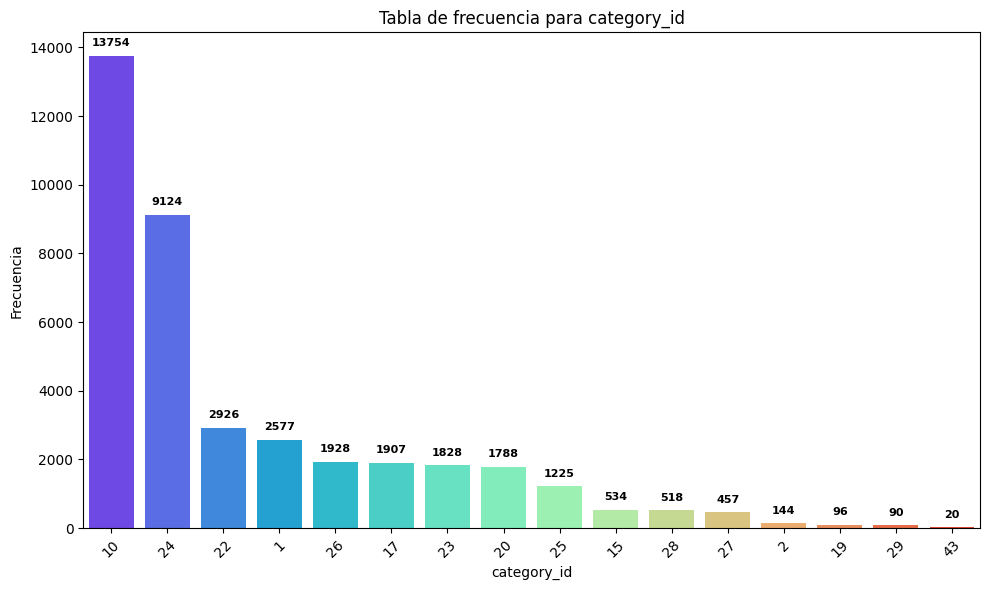

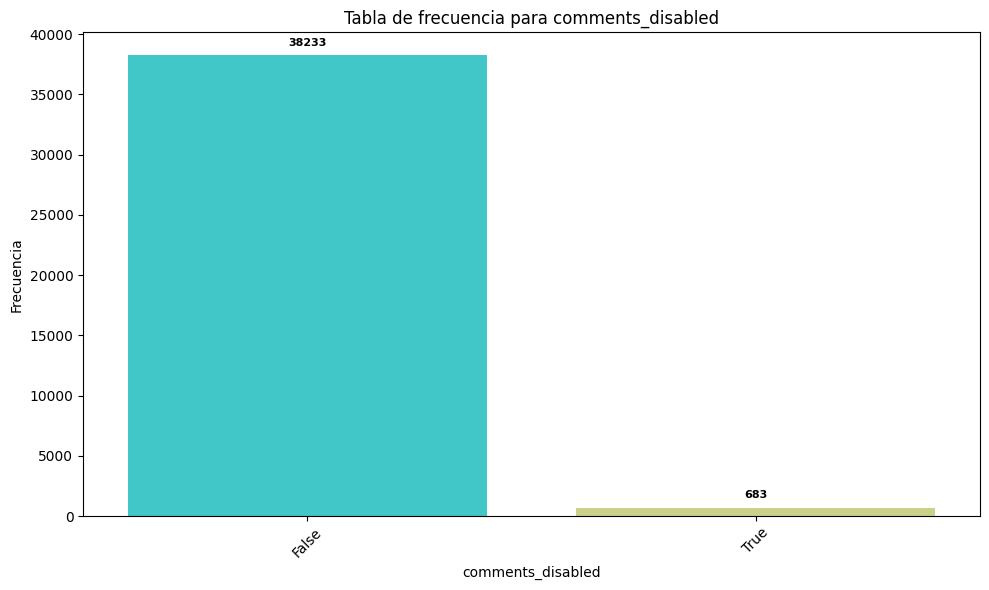

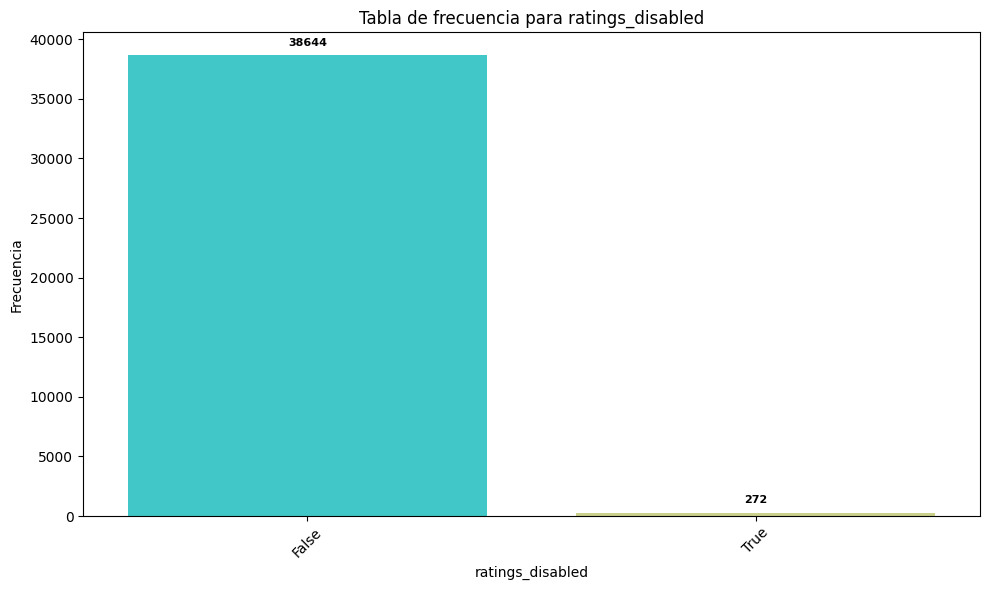

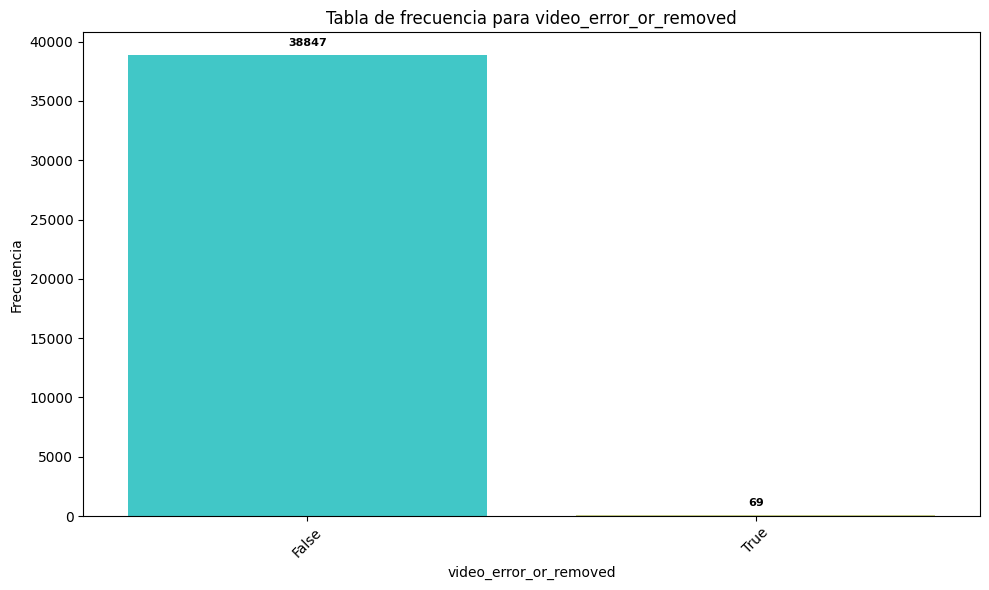

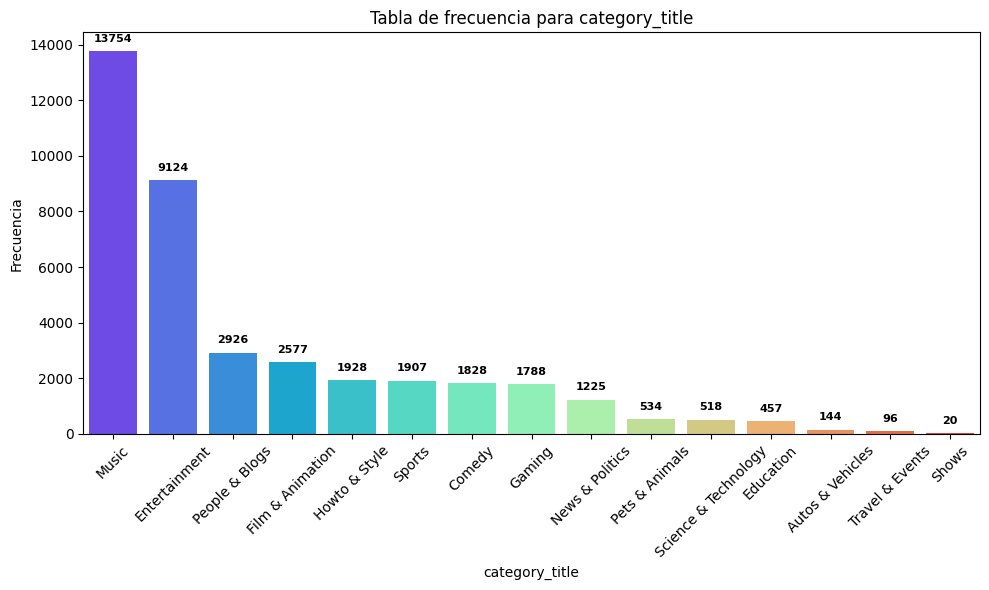

In [428]:

# Variables categóricas y booleanas para las cuales queremos mostrar gráficos
categorical = ['category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'category_title']

# Mostrar y guardar gráficos de barras para cada variable de interés
for var in categorical:
    # Calcular frecuencias
    freq_counts = videos_df[var].value_counts()
    
    # Crear gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=freq_counts.index.astype(str), y=freq_counts, palette='rainbow', hue=freq_counts.index.astype(str))
    
    # Mostrar la cantidad total encima de cada barra
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=8,
                    fontweight='bold')

    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.title(f'Tabla de frecuencia para {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
   

In [429]:
# Gráfico de distribución para cada variable numérica
numericas= videos_df.select_dtypes(include=['float64', 'int'])
numericas.describe()


,category_id,views,likes,dislikes,comment_count,lat,lon
count,38916.000000,3.891600e+04,3.891600e+04,3.891600e+04,3.891600e+04,38916.000000,38916.000000
mean,16.827937,5.911944e+06,1.345196e+05,7.612560e+03,1.308835e+04,53.383720,-2.379078
std,7.752728,1.900121e+07,3.499893e+05,5.095683e+04,5.066740e+04,2.043531,2.103878
min,1.000000,8.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,50.133722,-7.333284
25%,10.000000,2.515272e+05,5.897000e+03,2.000000e+02,6.790000e+02,51.499995,-3.529950
50%,20.000000,9.818890e+05,2.518250e+04,8.210000e+02,2.478000e+03,53.200020,-2.180007
75%,24.000000,3.683628e+06,1.140892e+05,3.357500e+03,9.241500e+03,54.879995,-1.080022
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06,58.966981,1.300013


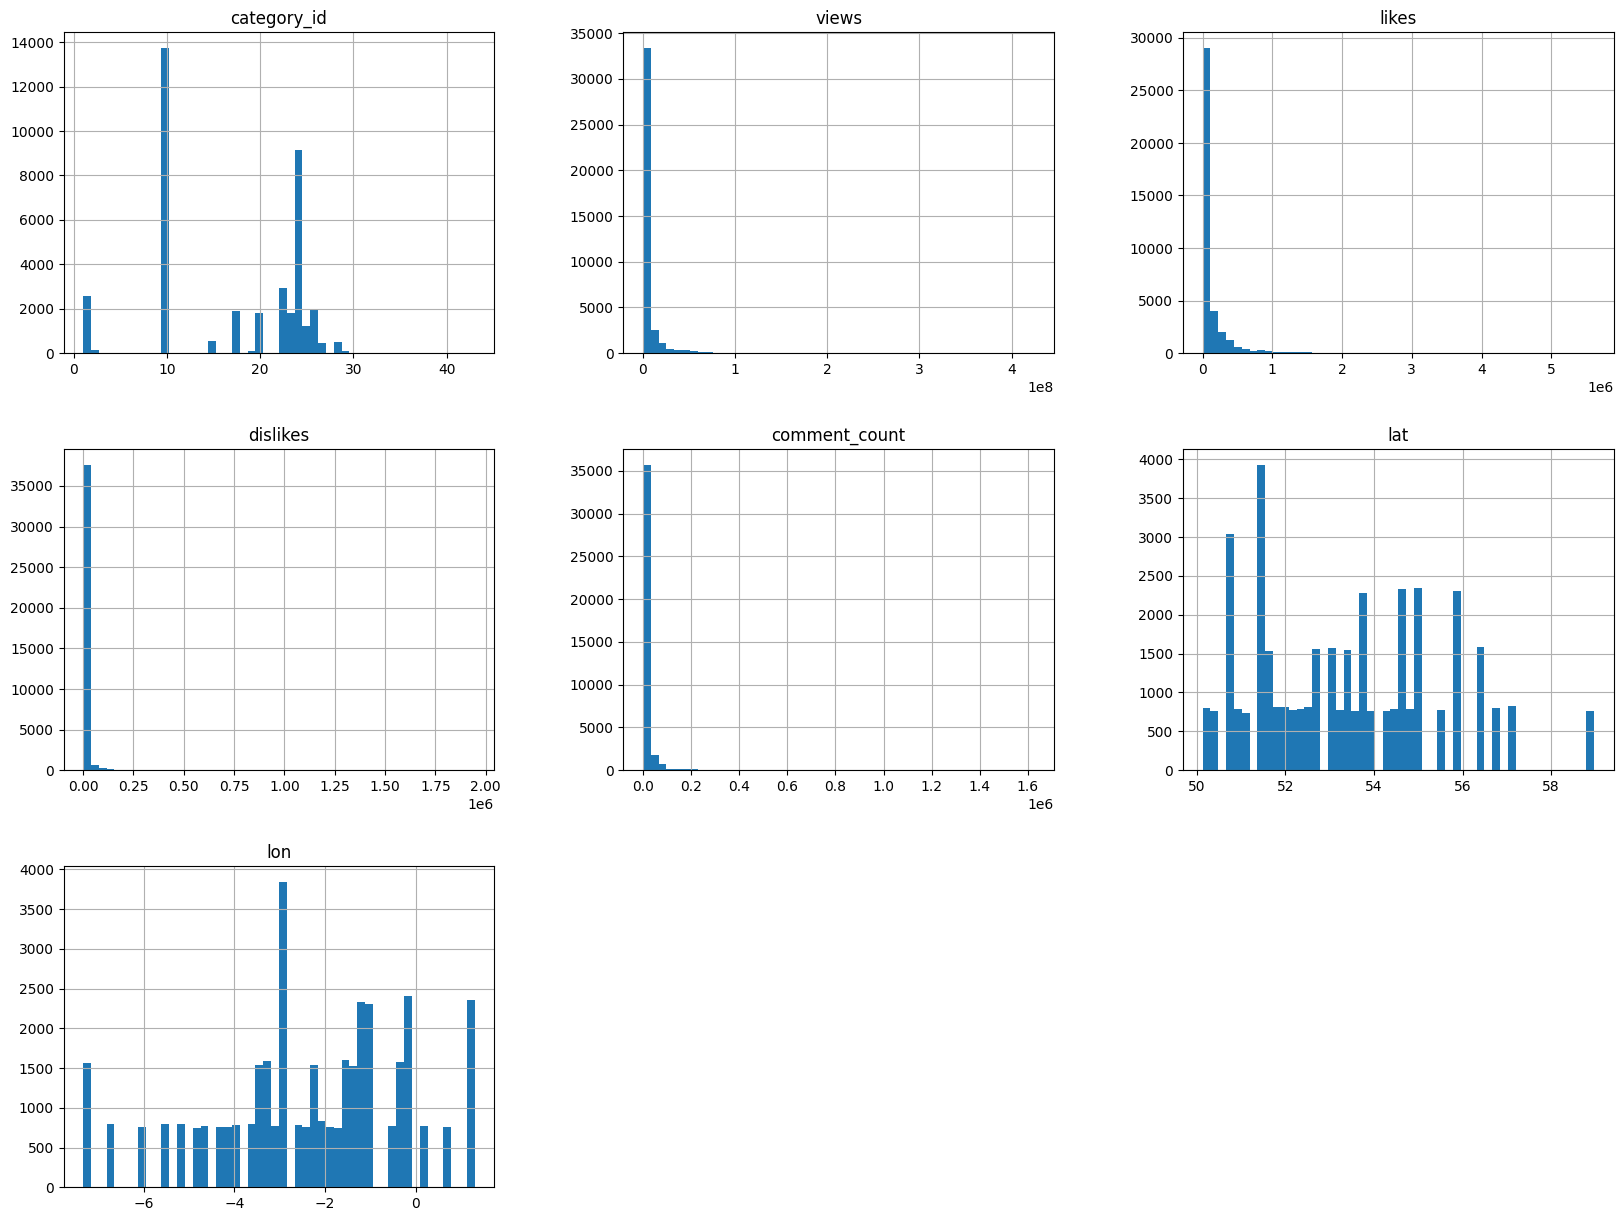

In [430]:
numericas.hist(bins=50,figsize=(20,15))
plt.show()

#### Verificación de calidad de datos


In [431]:
## Validamos el número de videos únicos en la base
len(videos_df.video_id.unique())

3272

In [432]:
## Validamos el número de categorias únicas en la base
len(videos_df.category_id.unique())

16

In [433]:
# Número de datos nulos por cada variable
# ==============================================================================
videos_df.isna().sum().sort_values()

video_id                    0
lon                         0
lat                         0
state                       0
video_error_or_removed      0
ratings_disabled            0
comments_disabled           0
thumbnail_link              0
geometry                    0
comment_count               0
likes                       0
views                       0
tags                        0
publish_time                0
category_id                 0
channel_title               0
title                       0
trending_date               0
dislikes                    0
category_title             90
description               612
dtype: int64

## Preparación de los datos

### Pre-procesar los datos

#### Eliminamos las columnas irrelevantes

In [434]:
#videos_df.comments_disabled.value_counts() // ver la cantidad
# Mantener sólo las columnas relevantes
columns_relevantes = [
    'video_id','category_title', 'views', 'likes', 'dislikes', 
    'comment_count', 'trending_date', 'channel_title', 'state',
    'lat','lon','geometry'
]
# Filtrar el DataFrame para mantener solo las columnas relevantes
videos_df = videos_df[columns_relevantes]

In [435]:
videos_df.head(5)

,video_id,category_title,views,likes,dislikes,comment_count,trending_date,channel_title,state,lat,lon,geometry
0,Jw1Y-zhQURU,Howto & Style,7224515,55681,10247,9479,17.14.11,John Lewis,Devon,50.700405,-3.529950,POINT (-3.529950197 50.70040529)
1,3s1rvMFUweQ,Entertainment,1053632,25561,2294,2757,17.14.11,Saturday Night Live,Manchester,53.500415,-2.247987,POINT (-2.247987103 53.50041526)
2,n1WpP7iowLc,Music,17158579,787420,43420,125882,17.14.11,EminemVEVO,Bath And North East Somerset,51.383749,-2.350022,POINT (-2.350022218 51.3837486)
3,PUTEiSjKwJU,Sports,27833,193,12,37,17.14.11,Salford City Football Club,Aberdeen,57.170398,-2.079987,POINT (-2.079987021 57.17039797)
4,rHwDegptbI4,News & Politics,9815,30,2,30,17.14.11,Cute Girl Videos,Southampton,50.900031,-1.399977,POINT (-1.399976849 50.90003135)


In [436]:
# valores nulos u outliers
null_counts = videos_df.isnull().sum()

In [437]:
# Calcular el porcentaje
percent_missing = (null_counts / len(videos_df)) * 100

In [438]:
# dataframe para los resultados
missing_data = pd.DataFrame({'Cantidad de Valores Nulos': null_counts, 'Porcentaje de Valores Nulos': percent_missing})

In [439]:
#Mostrar los valores nulos
missing_data = missing_data[missing_data['Cantidad de Valores Nulos'] > 0]
print(missing_data)

                Cantidad de Valores Nulos  Porcentaje de Valores Nulos
category_title                         90                     0.231267


In [440]:
#Imputar category_title con la moda
most_frequent_category = videos_df['category_title'].mode()[0]
videos_df['category_title'] = videos_df['category_title'].fillna(most_frequent_category)
videos_df.isna().sum().sort_values()
# No tratamos la variable descripción por que lo vamos a eliminar ya que no nos aporta nada

video_id          0
category_title    0
views             0
likes             0
dislikes          0
comment_count     0
trending_date     0
channel_title     0
state             0
lat               0
lon               0
geometry          0
dtype: int64

### Construimos nuevos datos

In [441]:
# Crear una nueva columna de proporción de "Me gusta" a "No me gusta"
videos_df['like_dislike_ratio'] = videos_df['likes'] / (videos_df['dislikes'] + 1)

In [442]:
# Crear una nueva columna de proporción de "Vistas" a "Comentarios"
videos_df['view_comment_ratio'] = videos_df ['views'] / (videos_df['comment_count'] + 1)

In [443]:
#Nuevos datos agregados al final de la data
videos_df.head(5)

,video_id,category_title,views,likes,dislikes,comment_count,trending_date,channel_title,state,lat,lon,geometry,like_dislike_ratio,view_comment_ratio
0,Jw1Y-zhQURU,Howto & Style,7224515,55681,10247,9479,17.14.11,John Lewis,Devon,50.700405,-3.529950,POINT (-3.529950197 50.70040529),5.433353,762.079641
1,3s1rvMFUweQ,Entertainment,1053632,25561,2294,2757,17.14.11,Saturday Night Live,Manchester,53.500415,-2.247987,POINT (-2.247987103 53.50041526),11.137691,382.027556
2,n1WpP7iowLc,Music,17158579,787420,43420,125882,17.14.11,EminemVEVO,Bath And North East Somerset,51.383749,-2.350022,POINT (-2.350022218 51.3837486),18.134543,136.305768
3,PUTEiSjKwJU,Sports,27833,193,12,37,17.14.11,Salford City Football Club,Aberdeen,57.170398,-2.079987,POINT (-2.079987021 57.17039797),14.846154,732.447368
4,rHwDegptbI4,News & Politics,9815,30,2,30,17.14.11,Cute Girl Videos,Southampton,50.900031,-1.399977,POINT (-1.399976849 50.90003135),10.000000,316.612903


In [444]:
#Datos completos
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            38916 non-null  object 
 1   category_title      38916 non-null  object 
 2   views               38916 non-null  int64  
 3   likes               38916 non-null  int64  
 4   dislikes            38916 non-null  int64  
 5   comment_count       38916 non-null  int64  
 6   trending_date       38916 non-null  object 
 7   channel_title       38916 non-null  object 
 8   state               38916 non-null  object 
 9   lat                 38916 non-null  float64
 10  lon                 38916 non-null  float64
 11  geometry            38916 non-null  object 
 12  like_dislike_ratio  38916 non-null  float64
 13  view_comment_ratio  38916 non-null  float64
dtypes: float64(4), int64(4), object(6)
memory usage: 4.2+ MB


In [445]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

In [446]:
corr_matrix = videos_df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
1,views,likes,0.795862,0.795862
8,likes,views,0.795862,0.795862
26,comment_count,dislikes,0.771772,0.771772
19,dislikes,comment_count,0.771772,0.771772
11,likes,comment_count,0.744361,0.744361
25,comment_count,likes,0.744361,0.744361
24,comment_count,views,0.466899,0.466899
3,views,comment_count,0.466899,0.466899
17,dislikes,likes,0.446746,0.446746
10,likes,dislikes,0.446746,0.446746


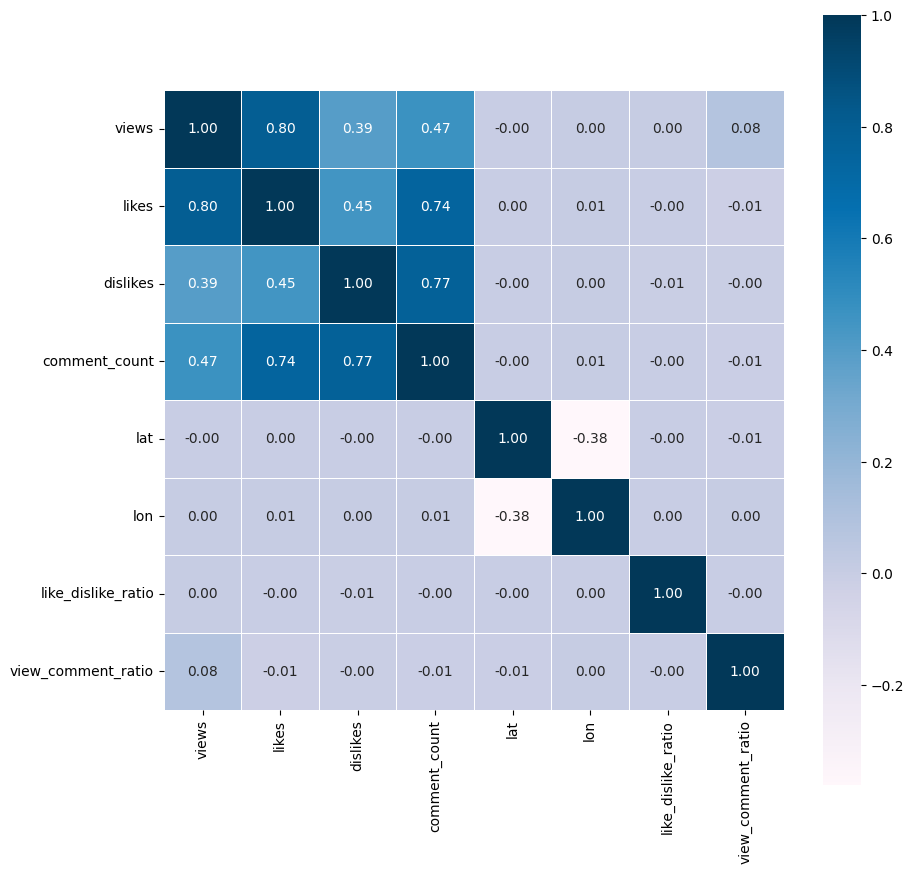

In [447]:
# Heatmap matriz de correlaciones
# ==============================================================================
corr = sns.heatmap(corr_matrix,
                   vmax = 1,
                   square = True,
                   linewidth = 0.5,
                   yticklabels = True,
                   xticklabels = True,
            cbar_kws = {'shrink' : 1},
                   annot = True,
                   fmt = '.2f',
                   cmap = 'PuBu')
corr.figure.set_size_inches(10,10)

In [448]:
# Guardamos la data limpia
videos_df.to_csv('videos_limpio.csv', index=True)

### Requerimmientos

In [449]:
path_file = r'C:/Users/KEVIN AGUILAR/Downloads/TFDS/'
# Cargamos el csv
df_nuevo = pd.read_csv(path_file + 'videos_limpio.csv', delimiter= ',')

In [450]:
df_nuevo = df_nuevo.drop('Unnamed: 0', axis=1)
df_nuevo.dtypes

video_id               object
category_title         object
views                   int64
likes                   int64
dislikes                int64
comment_count           int64
trending_date          object
channel_title          object
state                  object
lat                   float64
lon                   float64
geometry               object
like_dislike_ratio    float64
view_comment_ratio    float64
dtype: object

### Pregunta 1: ¿Qué categorías de videos son las de mayor tendencia?

category_title
Music                   171513663031
Entertainment            29786283041
Film & Animation          8362707626
People & Blogs            5754287829
Comedy                    3962062143
Sports                    3341736194
Gaming                    1746619532
Science & Technology      1641388256
News & Politics           1409131375
Howto & Style             1190155227
Pets & Animals             541320573
Education                  444290557
Autos & Vehicles           214184514
Travel & Events            132784993
Shows                       28583283
Name: views, dtype: int64


C:\Users\KEVIN AGUILAR\AppData\Local\Temp\ipykernel_6632\3774524766.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 1.0, 'Tendencias de Videos por Categoría')

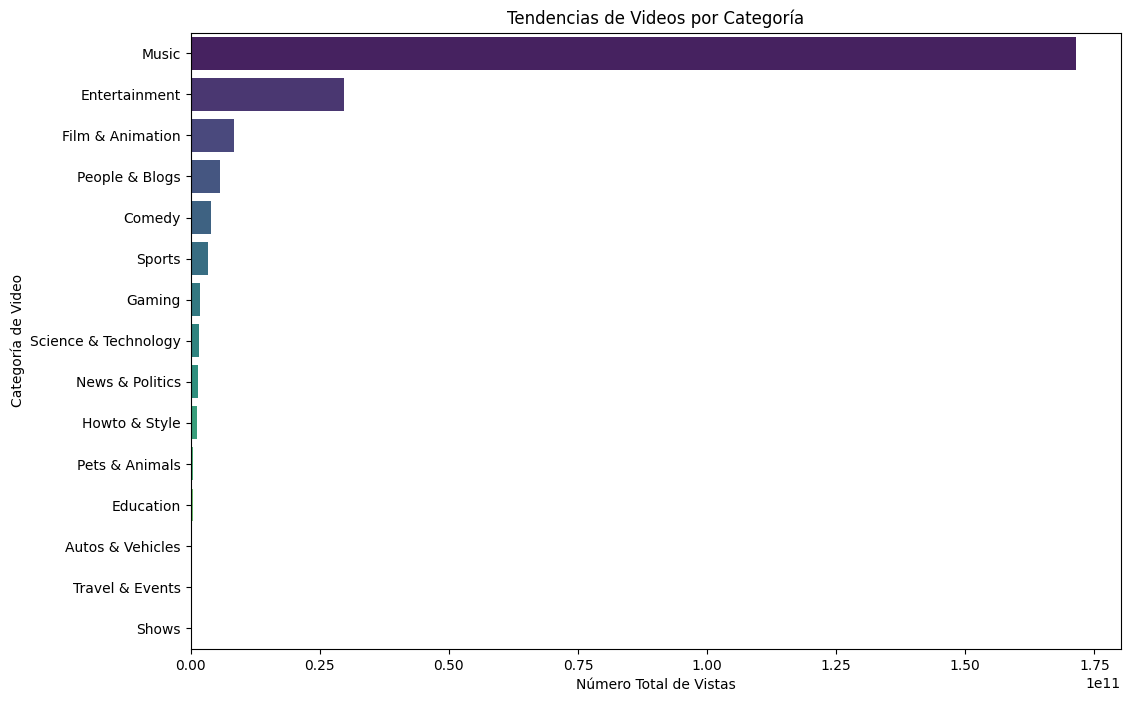

In [451]:
top_categories_views = df_nuevo.groupby('category_title')['views'].sum().sort_values(ascending=False)
print(top_categories_views)

# Configurar tamaño y estilo del gráfico
plt.figure(figsize=(12, 8))

# Crear gráfico de barras
sns.barplot(y=top_categories_views.index, x=top_categories_views.values, palette='viridis')

# Etiquetas y título del gráfico
plt.ylabel('Categoría de Video')
plt.xlabel('Número Total de Vistas')
plt.title('Tendencias de Videos por Categoría')

#### Podemos decir que la categoria demayor tendencia es Music, seguido de Entertaiment.

### Pregunta 2: ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?


Categorías de videos que más gustan (más likes):
category_title
Music                   3767445668
Entertainment            744266231
Film & Animation         147418633
Comedy                   143372176
People & Blogs           135396249
Sports                    74888487
Gaming                    70125588
Howto & Style             51360345
Science & Technology      31873124
News & Politics           30651565
Education                 17567394
Pets & Animals            15288374
Autos & Vehicles           3543625
Travel & Events             928747
Shows                       836738
Name: likes, dtype: int64

Categorías de videos que más gustan (más likes):


C:\Users\KEVIN AGUILAR\AppData\Local\Temp\ipykernel_6632\1815943498.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




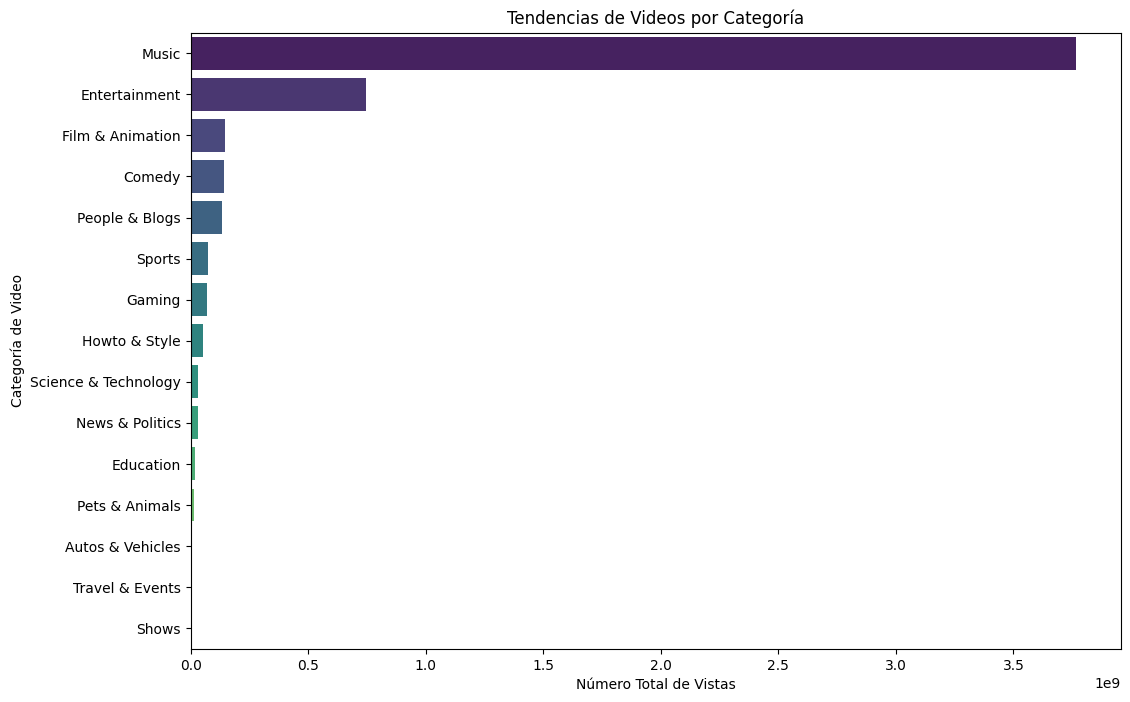

In [452]:
top_categories_likes = df_nuevo.groupby('category_title')['likes'].sum().sort_values(ascending=False)
print("\nCategorías de videos que más gustan (más likes):")
print(top_categories_likes)

# Configurar tamaño y estilo del gráfico
plt.figure(figsize=(12, 8))

# Crear gráfico de barras
sns.barplot(x=top_categories_likes.values, y=top_categories_likes.index, palette='viridis')

# Etiquetas y título del gráfico
plt.ylabel('Categoría de Video')
plt.xlabel('Número Total de Vistas')
plt.title('Tendencias de Videos por Categoría')
print("\nCategorías de videos que más gustan (más likes):")

#### Las categorías de videos con más likes son Music y Entertaiment con 3,767,445,668 y 744,266,231 likes respectivamente. Por otro lado, Las categorias 
#### de videos con menos likes y me gusta son Shows y Travel & Events con 928,747 y 836,738 respectivamente.

### Pregunta 3: ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Me gusta” / “No me gusta”?


Categorías de videos en proporción de 'Me gusta' a 'No me gusta':
category_title
Music                   156.815318
Shows                   131.304703
Travel & Events          75.643970
Pets & Animals           65.919310
People & Blogs           54.111969
Howto & Style            45.750441
Comedy                   45.585327
Education                44.368621
Gaming                   42.181376
Entertainment            41.645500
Science & Technology     40.751426
Film & Animation         37.277506
Autos & Vehicles         36.573658
Sports                   34.552086
News & Politics          13.870350
Name: like_dislike_ratio, dtype: float64


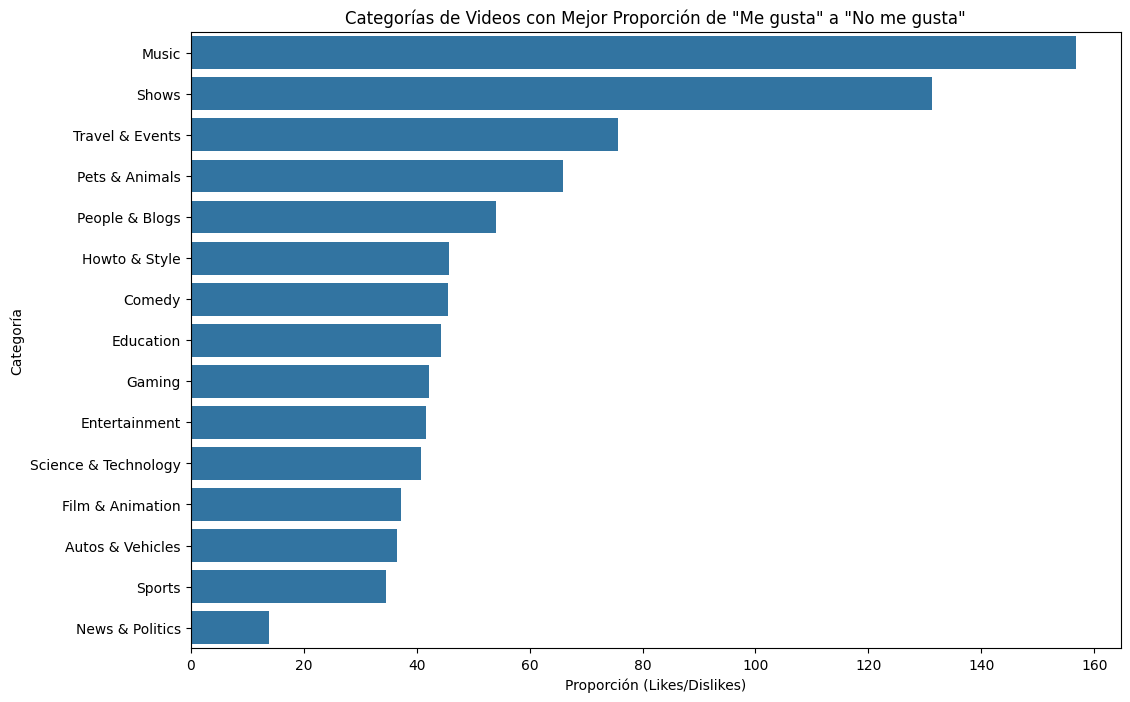

In [453]:
top_categories_like_dislike_ratio = df_nuevo.groupby('category_title')['like_dislike_ratio'].mean().sort_values(ascending=False)
print("\nCategorías de videos en proporción de 'Me gusta' a 'No me gusta':")
print(top_categories_like_dislike_ratio)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories_like_dislike_ratio.values, y=top_categories_like_dislike_ratio.index)
plt.title('Categorías de Videos con Mejor Proporción de "Me gusta" a "No me gusta"')
plt.xlabel('Proporción (Likes/Dislikes)')
plt.ylabel('Categoría')
plt.show()

#### Las categorias de videos que tienen un mejor ratio de "Me gustas" y "No me gustas" son Music y Shows con un ratio de 156 y 171 respectivamente.

### Pregunta 4: ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” / “Comentarios”?


Categorías de videos con mejor proporción de 'Vistas' a 'Comentarios':
category_title
People & Blogs          741094.022044
Science & Technology    458821.924719
Autos & Vehicles         92292.598248
Sports                   76194.104715
Entertainment            56392.391451
Film & Animation         55432.012623
Gaming                   37559.049978
Music                    13562.940304
News & Politics          10303.083358
Education                 1671.716500
Travel & Events           1385.475217
Comedy                     559.258214
Pets & Animals             513.781821
Howto & Style              455.931384
Shows                      350.369563
Name: view_comment_ratio, dtype: float64


C:\Users\KEVIN AGUILAR\AppData\Local\Temp\ipykernel_6632\435815453.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Categoría')

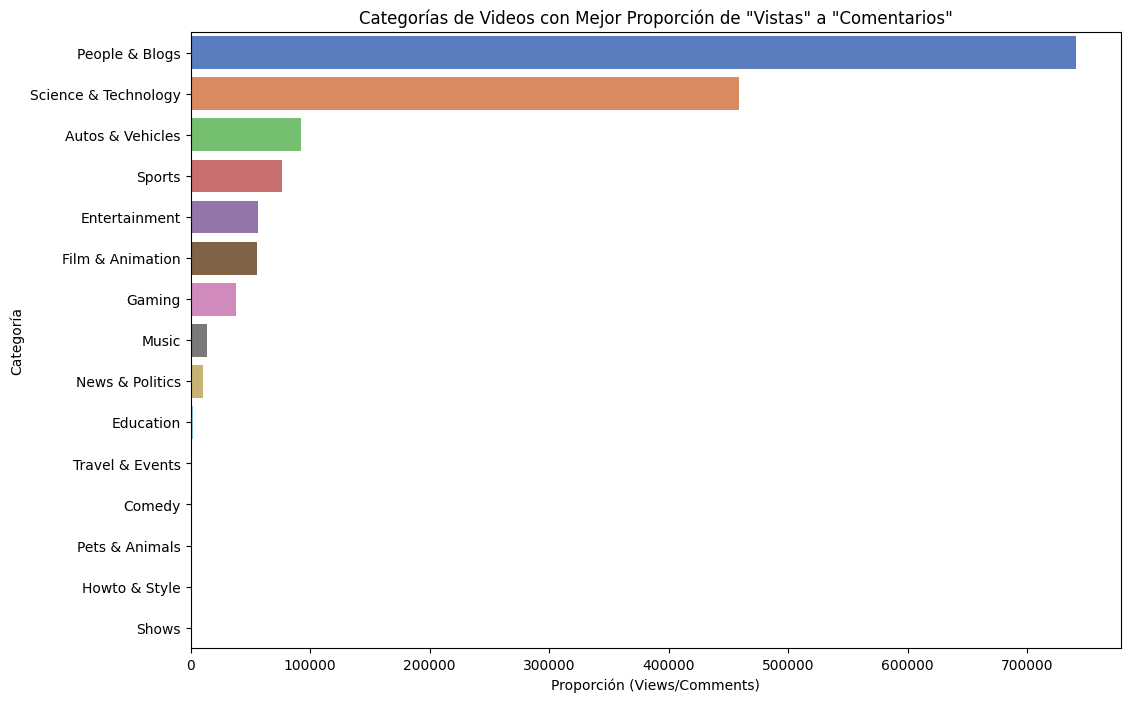

In [454]:
top_categories_view_comment_ratio = df_nuevo.groupby('category_title')['view_comment_ratio'].mean().sort_values(ascending=False)
print("\nCategorías de videos con mejor proporción de 'Vistas' a 'Comentarios':")
print(top_categories_view_comment_ratio)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories_view_comment_ratio.values, y=top_categories_view_comment_ratio.index, palette='muted')
plt.title('Categorías de Videos con Mejor Proporción de "Vistas" a "Comentarios"')
plt.xlabel('Proporción (Views/Comments)')
plt.ylabel('Categoría')

#### Las categorias de videos que tienen un mejor ratio de "Views" y "Comments" son People & Blogs y Science & Technology con 741094 y 458821 respectivamente.

### Pregunta 5: ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?


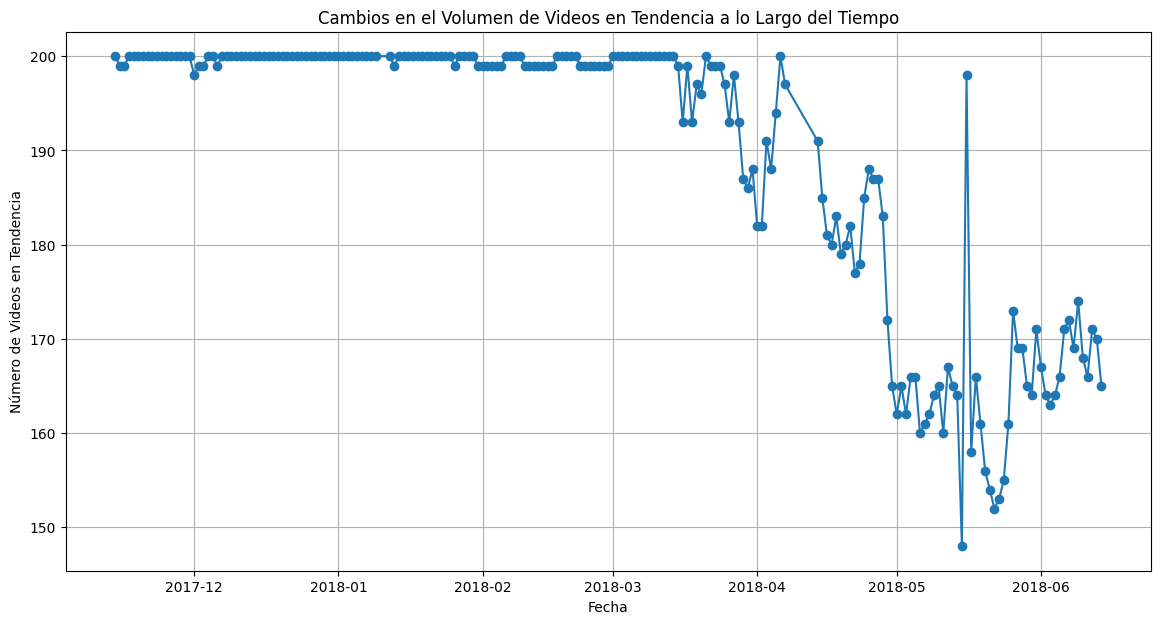

In [455]:
# Convertir 'trending_date' a formato datetime
df_nuevo['trending_date'] = pd.to_datetime(df_nuevo['trending_date'], format='%y.%d.%m')

# Agrupar por fecha y contar el número de videos en tendencia
trending_volume = df_nuevo.groupby('trending_date').size().reset_index(name='video_count')

# Plotear cambios en el volumen de videos en tendencia a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(trending_volume['trending_date'], trending_volume['video_count'], marker='o')
plt.title('Cambios en el Volumen de Videos en Tendencia a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Videos en Tendencia')
plt.grid(True)
plt.show()

#### Conforme van pasando los días el número de videos en tendencia disminuye

### Pregunta 6: ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?

In [456]:
channel_trend_counts = df_nuevo['channel_title'].value_counts()
top_channels = channel_trend_counts.head(10)
bottom_channels = channel_trend_counts[channel_trend_counts > 1].tail(10)

print("Top 10 canales más frecuentemente en tendencia:")
print(top_channels)

print("Top 10 canales menos frecuentemente en tendencia:")
print(bottom_channels)

Top 10 canales más frecuentemente en tendencia:
channel_title
The Tonight Show Starring Jimmy Fallon    208
Jimmy Kimmel Live                         207
TheEllenShow                              207
Saturday Night Live                       206
WWE                                       205
The Late Late Show with James Corden      202
Late Night with Seth Meyers               194
Breakfast Club Power 105.1 FM             193
The Late Show with Stephen Colbert        189
Netflix                                   187
Name: count, dtype: int64
Top 10 canales menos frecuentemente en tendencia:
channel_title
destinygame                              2
Interscope Records                       2
Hannah Witton                            2
JackConteExtras                          2
SunLife                                  2
Universal Pictures Home Entertainment    2
NoodleVlogs                              2
SUPERFRUIT                               2
colinfurze                               2
O

### Pregunta 7: ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”? 

In [457]:
# Agrupar los datos por región
region_data = df_nuevo.groupby('state').agg({
    'views': 'sum',
    'likes': 'sum',
    'dislikes': 'sum'
}).reset_index()

# Ordenar la tabla por número de vistas
region_data_sorted = region_data.sort_values(by='views', ascending=False)

# Mostrar la tabla
print(region_data_sorted)

                           state       views      likes  dislikes
39                   Southampton  5570080346  115414323   8617820
0                       Aberdeen  5482827742  117255591   7664138
41              Stockton On Tees  5458518084  107866359   5329842
38               South Yorkshire  5448546504  132686060   8451143
46                 West Midlands  5368026416  121579342   7366056
9                       Cornwall  5298639759  111092162   5580924
12                         Devon  5236283148  120366933   6640839
48                   Westminster  5142633271  118032685   6111115
16                     Edinburgh  5060494061  116546473   4904976
14                        Dundee  5023003418  110350746   4900039
24                         Luton  5020085252  101637332   5083773
33        Perthshire And Kinross  4990167458  119876590   5809542
13         Dumfries And Galloway  4982355430   96372370   6013210
23                     Leicester  4955744142  121366689   7640439
43        

## Modelizar y Evaluar los datos

### Técnicas de modelado

##### Se va aplicar regresión lineal para predecir el número de vistas, me gustas y no me gustas ya que necesitamos encontrar la relación entre la variable dependiente y las variables independientes. Por otro lado, se va a aplicacar regresión logística para responder a la pregunta 9 ya que este ejercicio nos solicita encontrar predecir la variable dependiente (0 o 1)

#### Regresión Lineal

In [466]:
# Variables independientes y dependientes para regresión lineal
X_linear = df_nuevo[['likes', 'dislikes', 'comment_count', 'like_dislike_ratio', 'view_comment_ratio']]
y_views = df_nuevo['views']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_views, test_size=0.3, random_state=42)

# Crear y entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train_linear, y_train_linear)

# Predecir con el modelo de regresión lineal
y_pred_linear = linear_model.predict(X_test_linear)

# Evaluar el modelo de regresión lineal
mse = mean_squared_error(y_test_linear, y_pred_linear)
r2 = r2_score(y_test_linear, y_pred_linear)

# Resultados
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

MSE: 87343480978039.42
R2 Score: 0.759701589193013


### Regresión Logística

In [459]:
# Crear la variable dependiente para la regresión logística
df_nuevo['trending'] = df_nuevo['trending_date'].apply(lambda x: 1 if x else 0)

In [460]:
# Verificar la distribución de la variable dependiente 'trending'
print(df_nuevo['trending'].value_counts())

trending
1    38916
Name: count, dtype: int64


In [461]:
# Variables independientes y dependientes para regresión logística
X_logistic = X_linear
y_trending = df_nuevo['trending']

In [462]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(X_logistic, y_trending, test_size=0.3, random_state=42)


In [ ]:
# Crear y entrenar el modelo de regresión logística
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_logistic, y_train_logistic)

In [ ]:
# Predecir con el modelo de regresión logística
y_pred_logistic = logistic_model.predict(X_test_logistic)
y_pred_prob = logistic_model.predict_proba(X_test_logistic)[:, 1]

In [ ]:
# Evaluar el modelo de regresión logística
conf_matrix = confusion_matrix(y_test_logistic, y_pred_logistic)
fpr, tpr, _ = roc_curve(y_test_logistic, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [ ]:
# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

In [ ]:
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Pregunta 8: ¿Es factible predecir el número de “Vistas” o “Me gusta” o “No me gusta”?

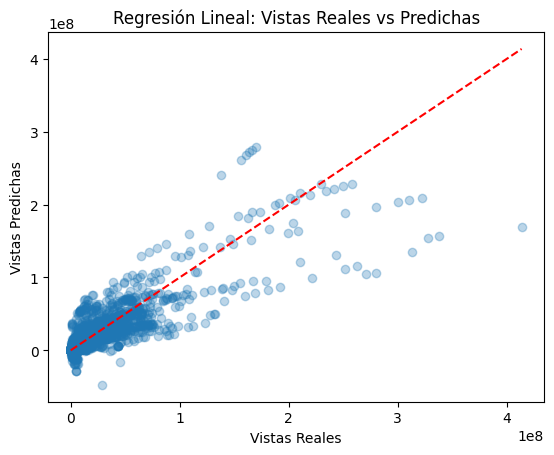

In [467]:
# Gráfica de resultados
plt.scatter(y_test_linear, y_pred_linear, alpha=0.3)
plt.plot([y_test_linear.min(), y_test_linear.max()], [y_test_linear.min(), y_test_linear.max()], color='red', linestyle='--')
plt.xlabel('Vistas Reales')
plt.ylabel('Vistas Predichas')
plt.title('Regresión Lineal: Vistas Reales vs Predichas')
plt.show()

### Pregunta 9: . ¿Los videos en tendencia son los que mayor cantidad de comentarios positivos reciben?


#### No me salio ya que solo hay un valor en trending